# Analyse ROMY Events

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees

## Configurations

The configuration contains the parameters for the analysis.
Here we load the data from the FDSN service.

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..", # output seed ID for sixdegrees stream
    'rot_seed': ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV"], #  Rotation sensor seed ID
    'tra_seed': ["GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "fdsn",  # "fdsn" | "sds" | "mseed_file"

    # FDSN service
    'fdsn_client_rot': "http://george",  # "IRIS",
    'fdsn_client_tra': "https://jane.geophysik.uni-muenchen.de",  # "IRIS",

    # rotate to ZNE
    'rotate_zne': True,

    # rotation for ROMY components (special case.. not required for pre-processed data)
    'use_romy_zne': True,
    'keep_z': True, # keep Z component from horizontal ring laser

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Get key information about the event

In [ ]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Distance: 22.7°
Backazimuth: 228.4°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [6]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching GR.FUR..BHZ data from FDSN
-> fetching GR.FUR..BHN data from FDSN
-> fetching GR.FUR..BHE data from FDSN
-> successfully removed response
-> rotating translational data to ZNE
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
GR.FUR..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching BW.ROMY.10.BJZ data from FDSN
-> fetching BW.ROMY..BJU data from FDSN
-> fetching BW.ROMY..BJV data from FDSN
-> successfully removed sensitivity
-> rotated ROMY data using rotate_romy_zne (keep_z=True)
rotating
3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
BW.ROMY..BJN   | 2023-09-08T22:12:58.999399Z - 2023-09-08T23:00:00.999399Z | 20.0 Hz, 56441 samples
BW.ROMY..BJE   | 2023-09-08T22:12:58.986601Z - 2023-0

Ensure that all traces of stream have the same sample size

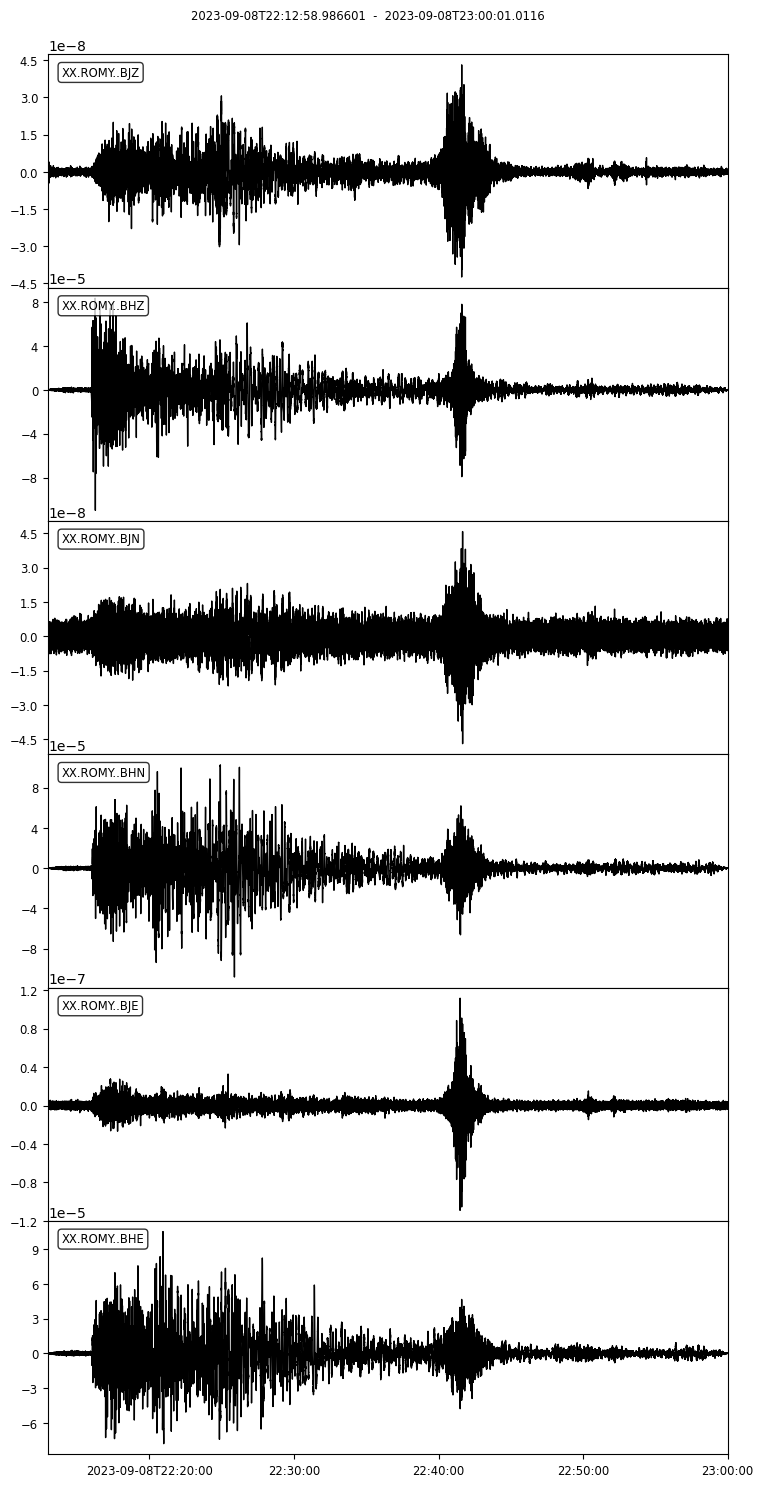

In [7]:
sd.st.plot(equal_scale=False);

In [8]:
sd.trim_stream(set_common=True, set_interpolate=False)

### Write data to file or SDS system

In [9]:
# write to mseed file
# sd.st.write(f"./data/romy_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

### Wavelet Comparsion

In [ ]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        cwt_results[f"{rot_data.stats.channel}"] = sd.compute_cwt(
            rot_data.times(), rot_data.data, rot_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        cwt_results[f"{acc_data.stats.channel}"] = sd.compute_cwt(
            acc_data.times(), acc_data.data, acc_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for ranslation")


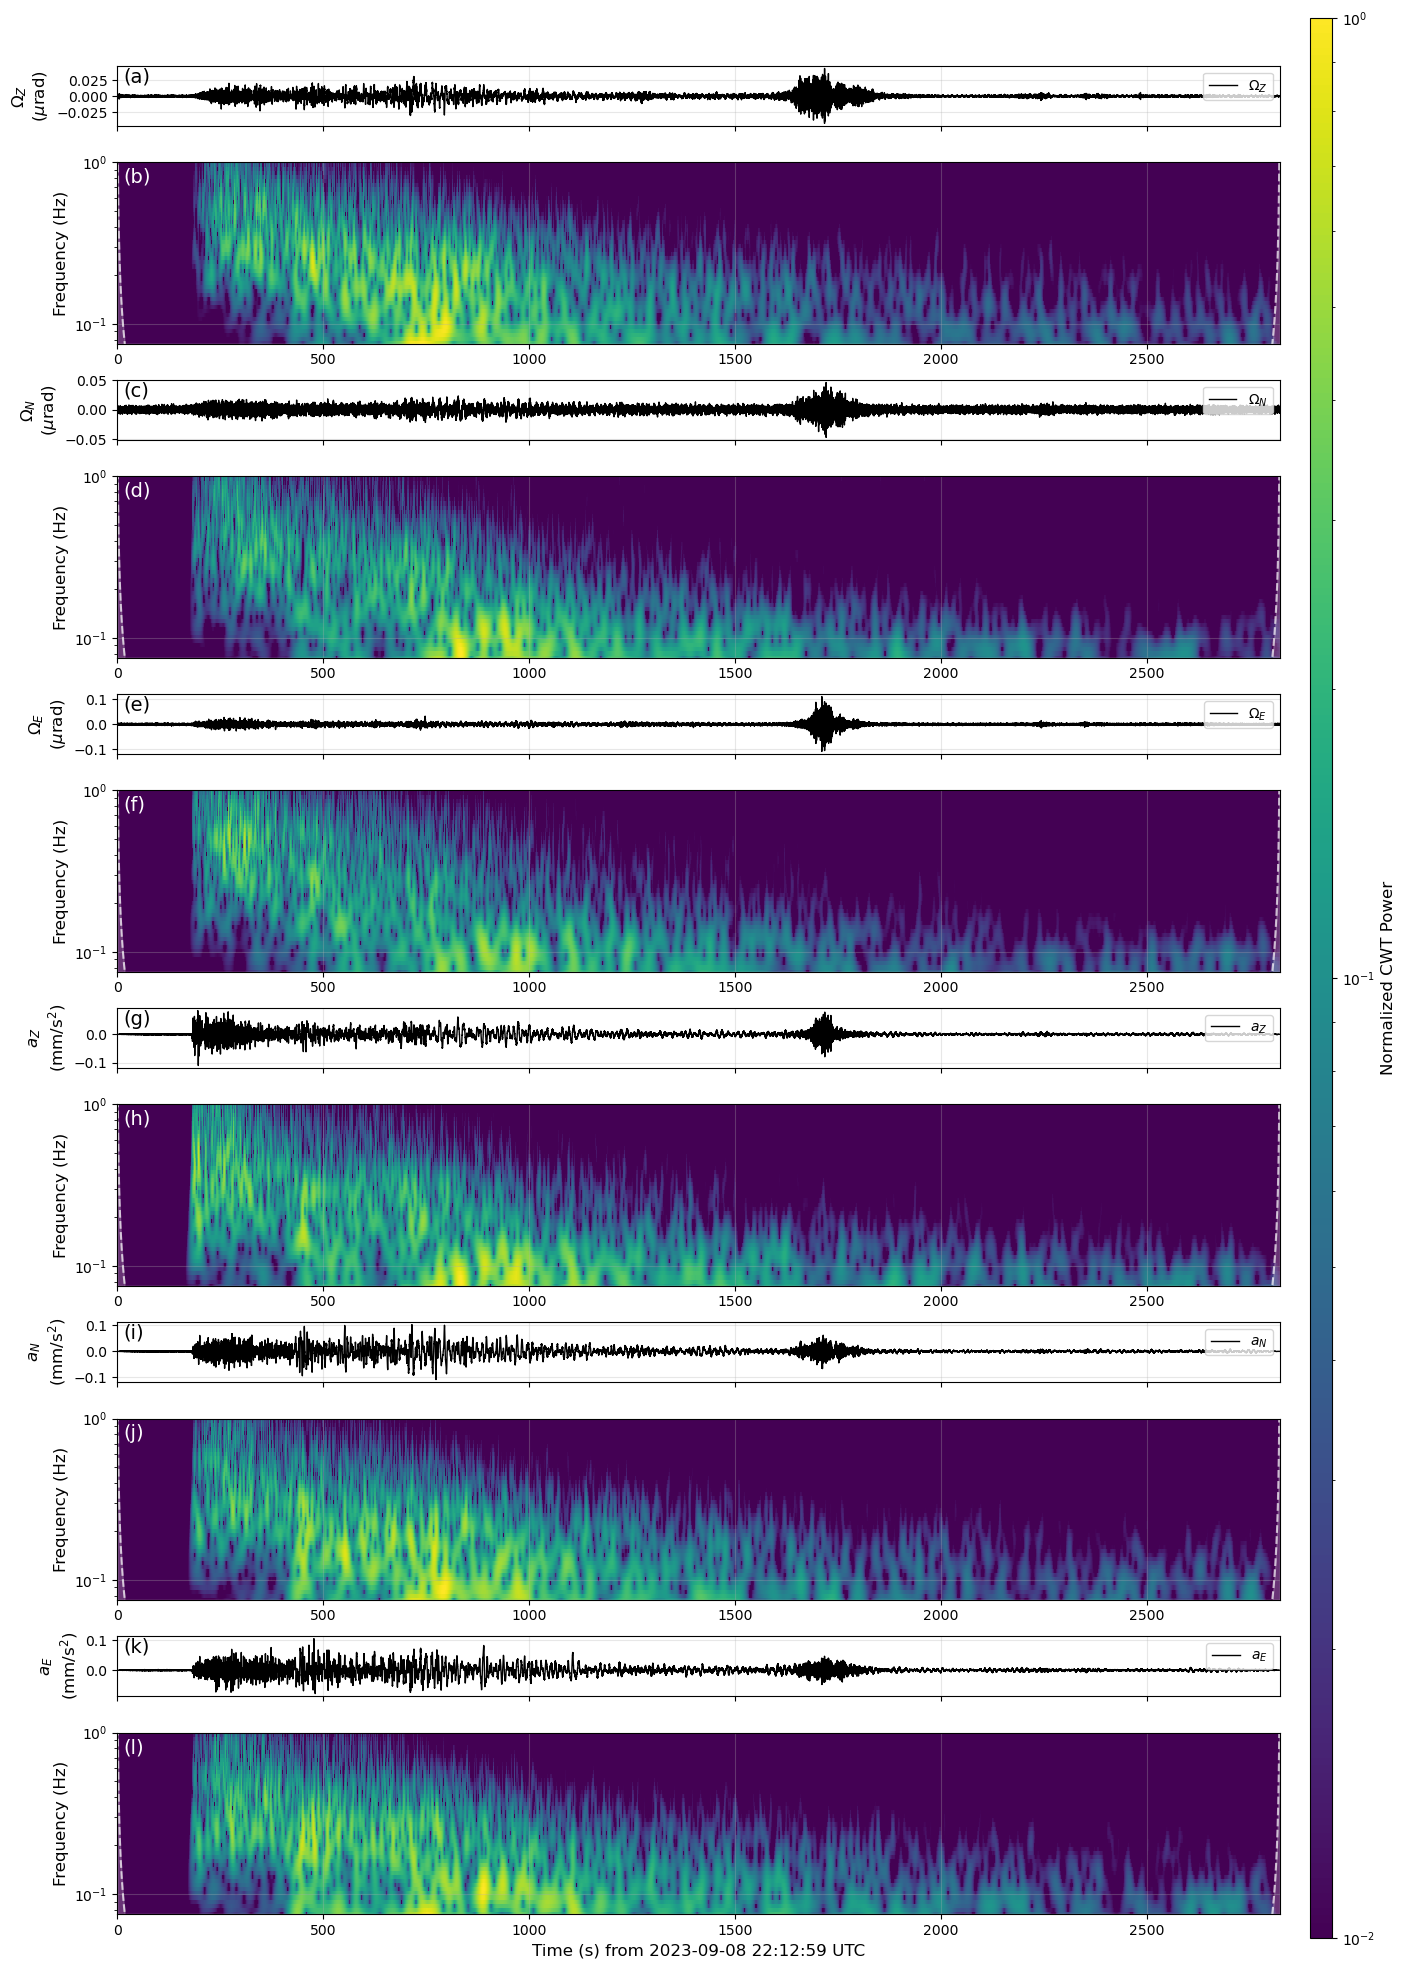

In [11]:
# Then plot all components
fig = sixdegrees.plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=1
)

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [12]:
sd.filter_data(fmin=0.02, fmax=0.2, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [13]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

let's compare the waveforms of the rotation (red) and translational (black) components 

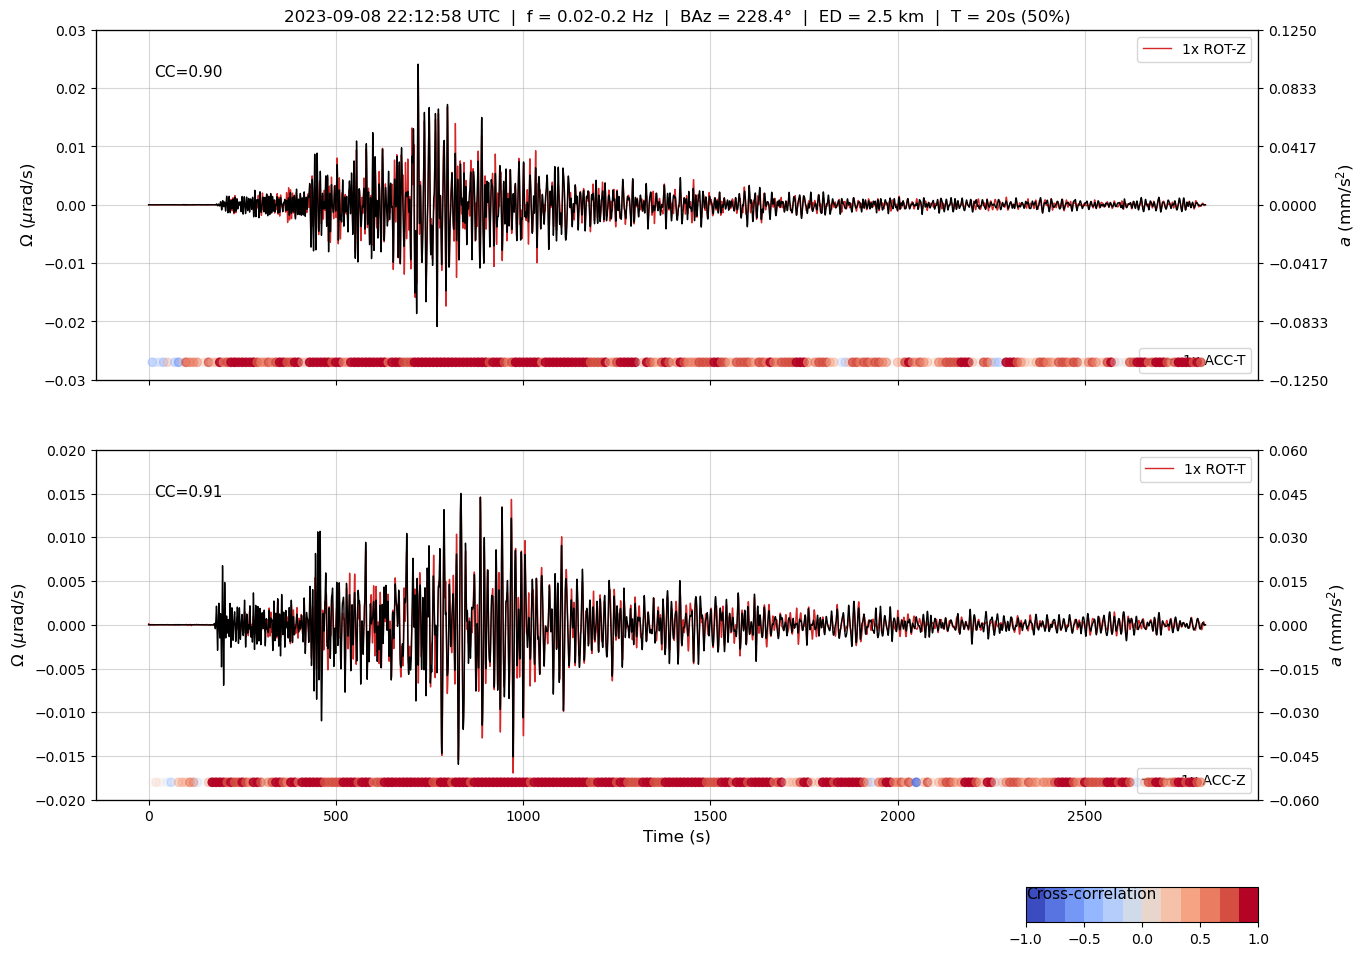

In [ ]:
fig = sd.plot_waveform_cc(
    rot0=sd.get_stream("rotation"),
    acc0=sd.get_stream("translation"),
    baz=ev['backazimuth'],
    distance=ev['distance_km'],
    fmin=sd.fmin,
    fmax=sd.fmax, 
    twin_sec=20,
    twin_overlap=0.5,
    wave_type="both"
)

In [ ]:
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)

### Compute Spectra

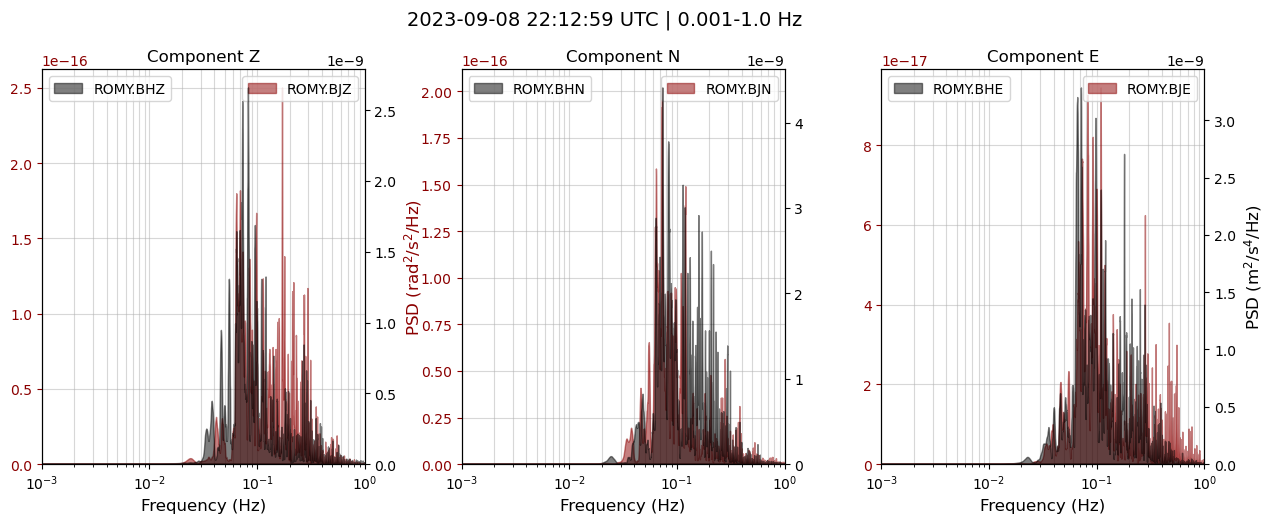

In [ ]:
fig = sd.plot_spectra_comparison_fill(
    rot=sd.get_stream("rotation", raw=True), 
    acc=sd.get_stream("translation", raw=True),
    fmin=0.001, fmax=1.0,
    ylog=False, xlog=True, fill=True
)

### Backazimuth Estimate


using love waves for backazimuth estimation ...
max = 236, mean = 236.0, std = 28.313218111768098


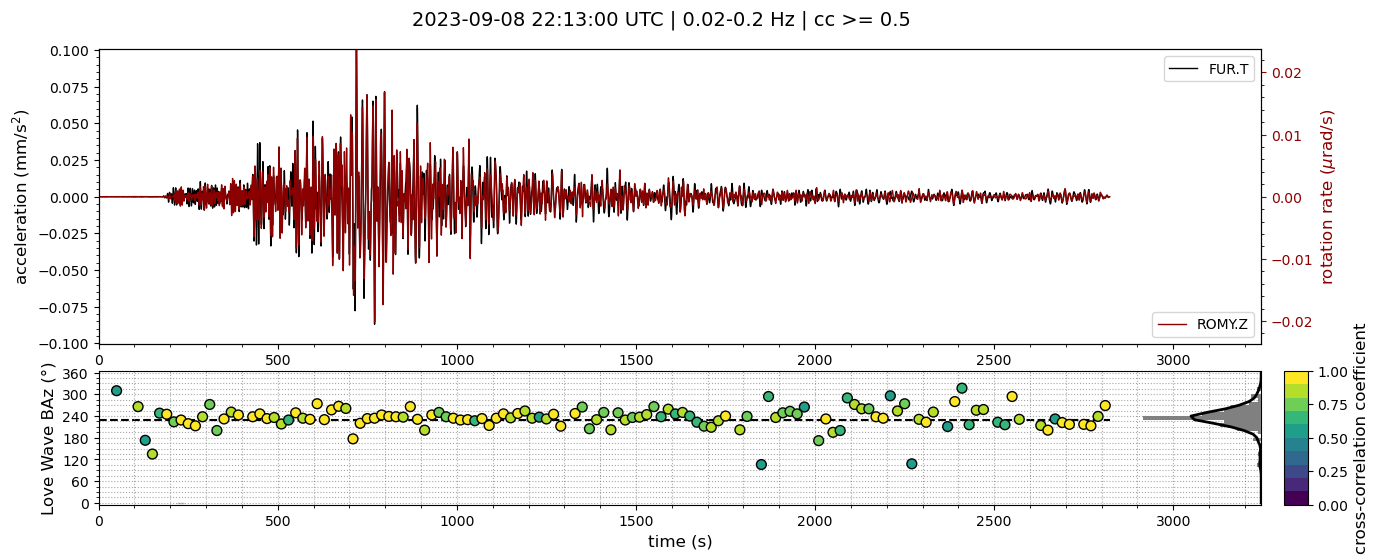

In [17]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=20,
    baz_win_sec_overlap=0.5,
    out=True
)

# Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)


using rayleigh waves for backazimuth estimation ...
max = 234, mean = 233.0, std = 33.88292207179576


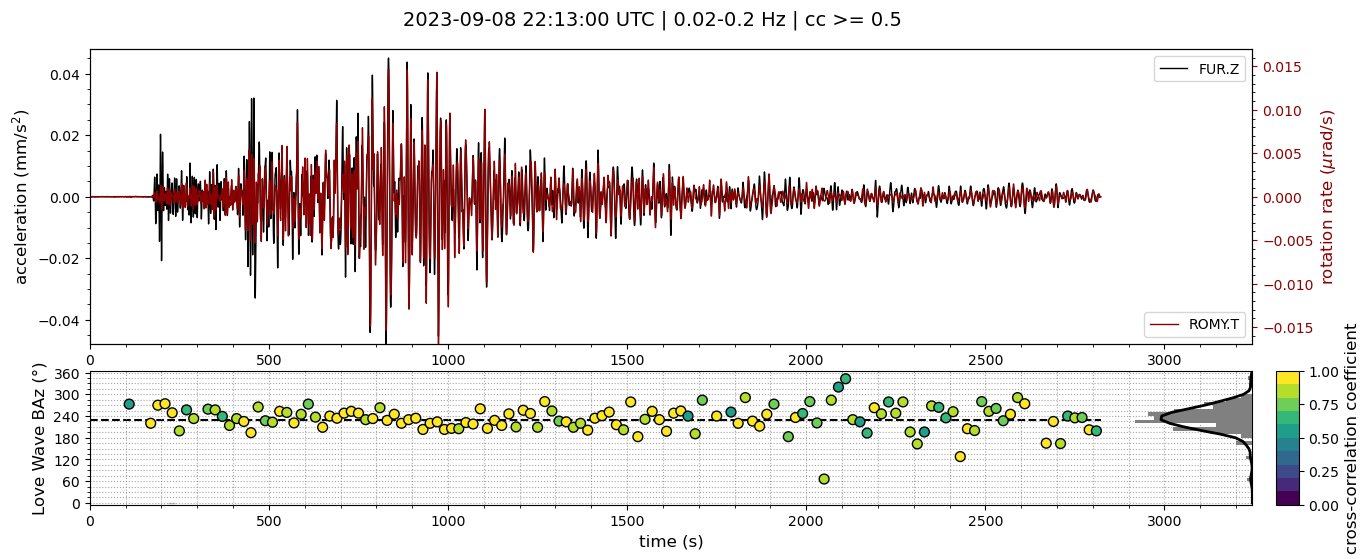

In [18]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=1,
    baz_win_sec=20,
    baz_win_sec_overlap=0.5,
    out=True
)

# # Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)


using love waves for backazimuth estimation ...

Estimated BAZ Love = 236° (CC ≥ 0.1)

using rayleigh waves for backazimuth estimation ...

Estimated BAZ Rayleigh = 235° (CC ≥ 0.1)

using tangent for backazimuth estimation ...

Estimated BAZ Tangent = 237° (CC ≥ 0.1)


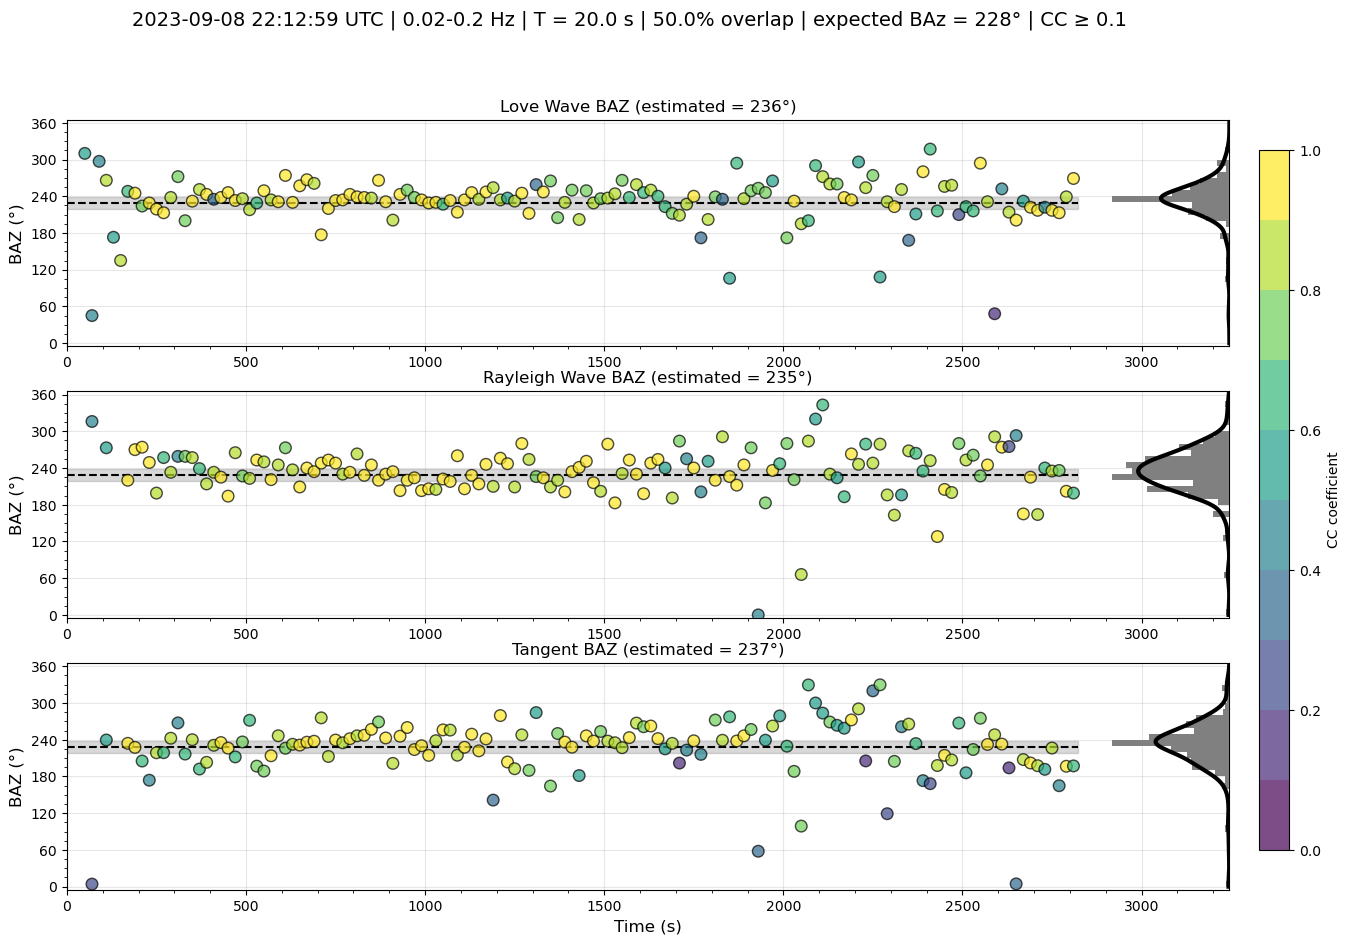

In [19]:
fig, results = sd.compare_backazimuth_methods(
    Twin=20.0,
    Toverlap=0.5,
    invert_rot_z=False,
    invert_acc_z=False,
    cc_threshold=0.1,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

In [ ]:
fig, results = sd.estimate_and_plot_backazimuth_simple(
    wave_types=['love', 'rayleigh'],
    event_info=ev,
    baz_step=1,
    baz_win_sec=20,
    baz_win_sec_overlap=0.5,
    cc_threshold=0.5,
    map_projection='orthographic'  # 'orthographic' or 'platecarree'
)

NameError: name 'sd' is not defined

### Analyse phase velocities

In [20]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

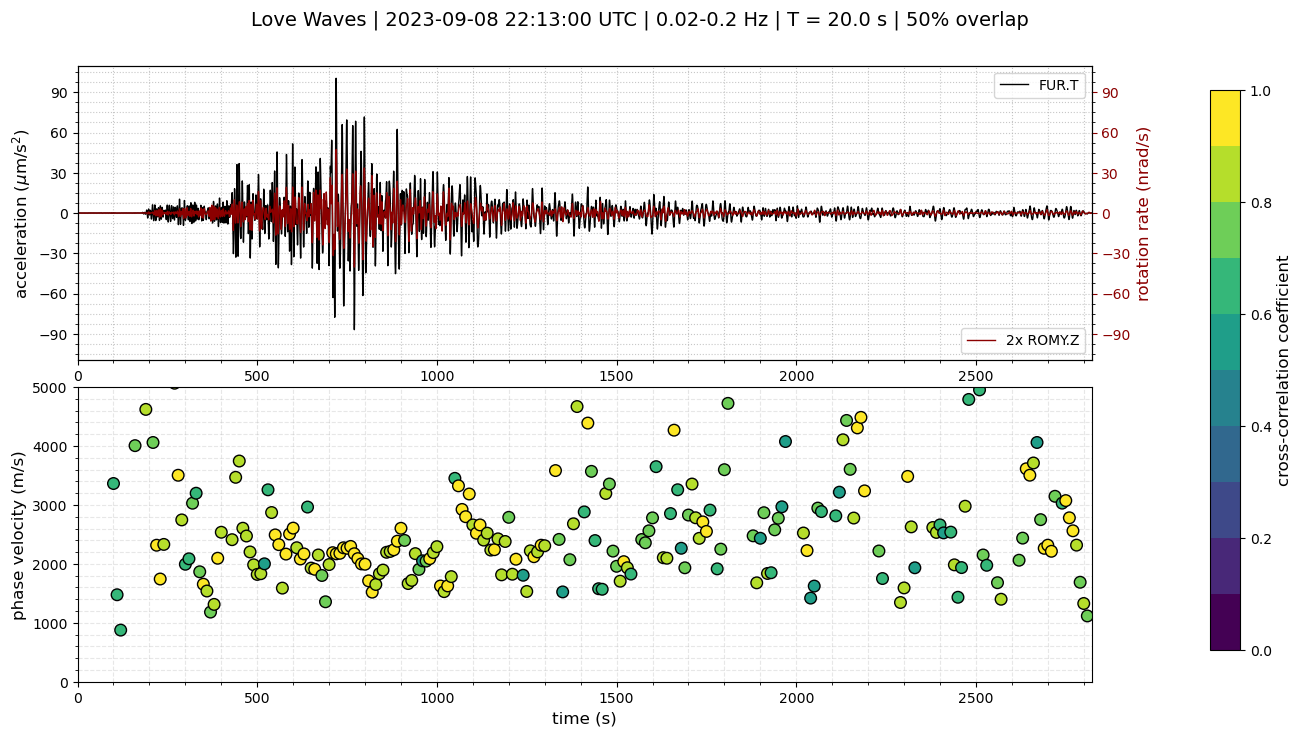

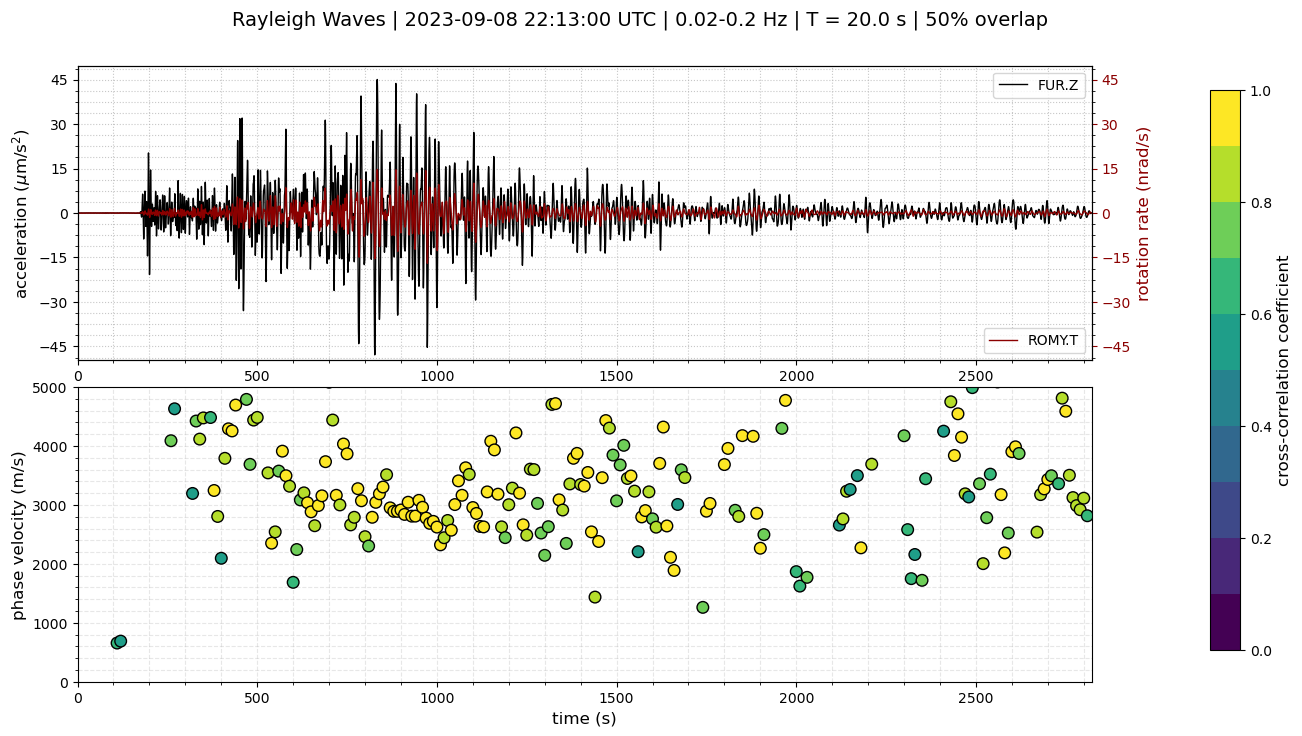

In [21]:
# Plot results
fig = sd.plot_velocities(
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = sd.plot_velocities(
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

## More Experimental

Here we estimate the velocities in time windows rather than assuming a constant backazimuth.

In [27]:
love_velocities_win = sd.compute_velocities_in_windows(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    adjusted_baz=True,
)


using love waves for backazimuth estimation ...


In [2]:
fig = sd.plot_velocities_win(
    results_velocities=love_velocities_win,
    cc_threshold=0.75,  # Only show results with CC >= 0.75
    baz_theo=ev['backazimuth'],     # Add reference
)

NameError: name 'sd' is not defined

### Compare RANSAC and ODR

Here we compare the RANSAC and ODR methods for estimating the velocities.

In [23]:
# Compute Love wave velocities
love_velocities_ransac = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_ransac = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Love wave velocities
love_velocities_odr = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.7,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_odr = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.7,
    method='odr',
    baz=ev['backazimuth']  # optional
)

In [29]:
fig = sd.plot_velocity_method_comparison(rayleigh_velocities_ransac,
                                         rayleigh_velocities_odr)

NameError: name 'rayleigh_velocities_ransac' is not defined